# Hand Gesture Classification
### by Adrian Abraham

## 1 - Package installation
- **tensorflow**: for model creation and predictions
- **pandas**: for csv reading
- **numpy**: for data storage and manipulation
- **scikit-learn**: to split data into training and cross val sets
- **matplotlib**: to plot learning curves and view model performance
- **ast**: to convert string literal lists into actual lists

In [22]:
!pip install tensorflow

In [23]:
!pip install pandas

In [25]:
!pip install scikit-learn

In [26]:
!pip install matplotlib

## 2 - Importing packages

In [27]:
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import L2

### Quick check that tensorflow is working

In [28]:
print(tf.__version__)

2.16.2


## 3 - Data import and manipulation

Each class data is stored in a csv file, which are collectively stored in the data folder. We will take all the data points and store them in one np array.

In [29]:
# Using glob to get all .csv files in the data folder
csv_names = glob.glob('data/*.csv')
csv_names.sort()
dfs = []
# Every .csv file is read using the pandas library and added to a list of DataFrames
for name in csv_names:
    dfs.append(pd.read_csv(name))

# The ast library is then used to convert the string literal lists into actual lists
# Then, each list is concatenated with each other to form one big np array of data
all_data = []
for df in dfs:
    # For each element in the Series df['coords'], we apply the function ast.literal_eval
    # to turn the string literals into lists
    df['coords'] = df['coords'].apply(ast.literal_eval)

    # The Series df['coords'] is then turned into a list using the tolist() function
    # and finally passed into np.array() to create a np array
    df_as_arr = np.array(df['coords'].tolist())
    
    all_data.append(df_as_arr)
data = np.concatenate(all_data, axis=0)

We can check its shape to verify how many points we have in the dataset and how many hand landmark coordinates are stored in each element.

In [30]:
data.shape

(10748, 21, 2)

Now we can create the target classes for each element of the dataset.

In [31]:
# We are taking each file name and extracting the gesture name
gestures = []
for name in csv_names:
    # We split the name at the '/' and get the last element, the csv file name, and remove the .csv extension
    gesture = name.split('/')[-1].replace('.csv', '')
    gestures.append(gesture)
print(f'Gestures to be detected: {gestures}')

Gestures to be detected: ['fist', 'four', 'massive_l', 'none', 'ok', 'peace', 'rock_on', 'shaka', 'thumbs_down', 'thumbs_up', 'whats_up_brother']


In [32]:
# Generating the target outputs for all dataset
targets = []
for i in range(len(all_data)):
    targets.append(np.full(all_data[i].shape[0], i))
targets = np.concatenate(targets, axis=0)

The training examples are split into the training set and validation set so that the validation set can be tested on the model after being trained. This will prevent overfitting the data.

In [33]:
# Splitting dataset into training set and cross validation set
data_train, data_cv, target_train, target_cv = train_test_split(data, targets, test_size=0.35, random_state=42)

## 4 - Neural network
A sequential neural network will be used for our model. The model will take the hand landmark coordinates as input and output a classification of one of the gestures it has trained on. Each of the 3 hidden layers use the ReLU activation function and L2 regularization to prevent overfitting.

In [44]:
l = 0.0001 # Regularization parameter
model = Sequential([
    Input(shape=data.shape[1:]),                                                    # Define the input shape here
    Flatten(),                                                                      # Flatten the (21, 2) input into a 1D vector
    Dense(64, activation='relu',  name='L1', kernel_regularizer=L2(l)),             # Fully connected layer with 64 neurons
    Dense(32, activation='relu',  name='L2', kernel_regularizer=L2(l)),             # Fully connected layer with 32 neurons
    Dense(20, activation='relu',  name='L3', kernel_regularizer=L2(l)),             # Fully connected layer with 20 neurons
    Dense(len(gestures), activation='linear', name='L4', kernel_regularizer=L2(l))  # Output layer for multiclass classification
])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L1 (Dense)                      │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L4 (Dense)                      │ (None, 11)             │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,723 (22.36 KB)

 Trainable params: 5,723 (22.36 KB)

 Non-trainable params: 0 (0.00 B)

The optimizer of this neural network uses Adam, meaning the learning rate is adjusted for each paramter for efficiency. The loss function used is SparseCategoricalCrossentropy, which is great for multiclassification because each example will belong to one of several classes. (these classes are in integer form) We don't convert the raw scores into probabilty yet for numerical stability. (the scores will be converted in `gesture_detection.py` using softmax)

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

The model is finally trained using the training data and the validation data will be used to test the model each epoch. The values of these will be shown after each epoch.

In [46]:
history = model.fit(
    data_train,target_train,
    epochs=50,
    validation_data=(data_cv,target_cv),
    verbose=1
)
print("Model successfully trained!")

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2947 - loss: 2.0660 - val_accuracy: 0.8046 - val_loss: 1.0224
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.8063 - loss: 0.8211 - val_accuracy: 0.9072 - val_loss: 0.4495
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9049 - loss: 0.4132 - val_accuracy: 0.9232 - val_loss: 0.3138
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.9228 - loss: 0.2951 - val_accuracy: 0.9351 - val_loss: 0.2521
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.9417 - loss: 0.2297 - val_accuracy: 0.9460 - val_loss: 0.2287
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.9368 - loss: 0.2184 - val_accuracy: 0.9514 - val_loss: 0.1826
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.9528 - loss: 0.1689 - val_accuracy: 0.9524 - val_loss: 0.1799
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.9601 - loss: 0.1614 - val_

The model is exported to then be used by `gesture_detection.py`

In [47]:
model.save("gesture_model.keras")

## 5 - Plotting learning curves
Plotting the training and validation set's loss and accuracy values will show us the performance of the model.

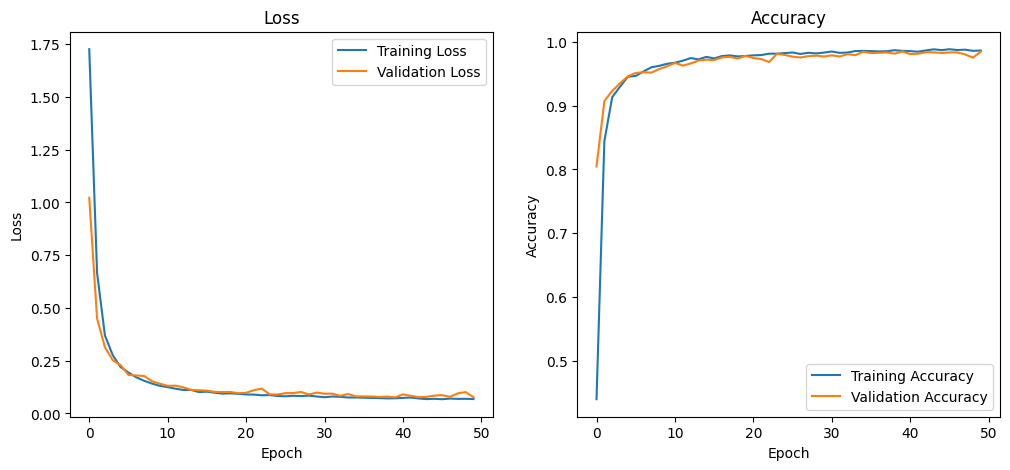

In [48]:
# Plotting learning curves
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


After plotting we can notice that with each epoch the loss decreases and accuracy increases. The loss stays relatively low for both the data and validation set showing that our model is working with great performance.